# Global Forecasting with `sktime`

### Overview of this notebook

* introduction - global forecasting
* global forecast without exogeneous data
* global forecast with exogeneous data

In [56]:
%%capture
import warnings

warnings.filterwarnings("ignore")

import sys

py_exe = sys.executable

!{py_exe} -m pip install pytorch_forecasting==1.0.0

### What is global forecast?

1. What is global forecast about?
  
    A lot of deep learning models will 
    
    - train on large dataset which containing many time series from many instances 
    - predict on time series from other instances beyond training data. 
    
    The ability to train on many series and predict beyond training data is called global forecast.

2. How is global forecast formulated?

   - train on dataset containing $n$ time series $\{x_{i_1}, x_{i_2}, x_{i_3}, ..., x_{i_n}\}$
   - predict on another set of time series $\{x_{j_1}, x_{j_2}, x_{j_3}, ..., x_{j_m}\}$
   - $m$ is not required to be equal to $n$
   - there might or might not be intersection between the sets $\{i_1,.., i_n\}$ and $\{j_1, ... j_m\}$


To check the global forecast ability of one forecaster in sktime, you can check the `capability:global_forecasting` tag.

In [57]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingDeepAR

PytorchForecastingDeepAR().get_tag(
    "capability:global_forecasting"
)  # should return True

True

### Global Forecast without exogeneous data

You can pass $n$ series of `y` to `fit` and then predict on other $m$ series different from data in training. 

First we generate 90 series for training and 10 series to predict.

In [58]:
from sktime.utils._testing.hierarchical import _make_hierarchical
from sklearn.model_selection import train_test_split

data = _make_hierarchical(
    hierarchy_levels=(100, 1), max_timepoints=10, min_timepoints=10, n_columns=1
)
data = data.droplevel(1)
y_train, y_test = train_test_split(data, test_size=0.1, train_size=0.9, shuffle=False)

`y_train` is the series we want to fit on which contains the first 90% of the time series instances.

In [59]:
y_train

c0
h0    time                
h0_0  2000-01-01  4.123547
      2000-01-02  5.742957
      2000-01-03  3.235366
      2000-01-04  4.776809
      2000-01-05  5.137263
...                    ...
h0_89 2000-01-06  3.979328
      2000-01-07  5.656471
      2000-01-08  5.146759
      2000-01-09  5.237537
      2000-01-10  3.849786

[900 rows x 1 columns]

`y_test` is the series we want to predict on which contains the last 10% of the time series instances.

In [60]:
y_test

c0
h0    time                
h0_90 2000-01-01  5.507207
      2000-01-02  5.016982
      2000-01-03  5.816398
      2000-01-04  5.840714
      2000-01-05  3.948941
...                    ...
h0_99 2000-01-06  3.049137
      2000-01-07  4.332526
      2000-01-08  4.540341
      2000-01-09  4.334228
      2000-01-10  5.703869

[100 rows x 1 columns]

You can see that `y_train` and `y_test` are different on hierarchical level `h0` which indicates that they come from different instances.

We can initialize a gloabl forecaster to fit on `y_train` and predict on `y_test`.

In [61]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats

model = PytorchForecastingNBeats(
    trainer_params={
        "max_epochs": 5,  # for quick test
        "limit_train_batches": 50,  # for quick test
    },
    dataset_params={
        "max_encoder_length": 3,
    },
)

In [62]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon([1, 2, 3], is_relative=True)
model.fit(y=y_train, fh=fh)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.375     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


PytorchForecastingNBeats(dataset_params={'max_encoder_length': 3},
                         trainer_params={'limit_train_batches': 50,
                                         'max_epochs': 5})

Then we can predict on `y_test` which is not included in `y_train`.

In [63]:
y_pred = model.predict(y=y_test, fh=fh)
y_pred

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c0
h0    time                
h0_90 2000-01-11  4.152288
      2000-01-12  3.907635
      2000-01-13  3.760190
h0_91 2000-01-11  4.601761
      2000-01-12  4.594269
      2000-01-13  4.606614
h0_92 2000-01-11  5.176336
      2000-01-12  5.179501
      2000-01-13  5.215404
h0_93 2000-01-11  4.319064
      2000-01-12  4.072730
      2000-01-13  3.933773
h0_94 2000-01-11  4.658298
      2000-01-12  4.658960
      2000-01-13  4.677829
h0_95 2000-01-11  4.688289
      2000-01-12  4.680397
      2000-01-13  4.684800
h0_96 2000-01-11  4.680850
      2000-01-12  4.758391
      2000-01-13  4.820650
h0_97 2000-01-11  5.032910
      2000-01-12  5.041520
      2000-01-13  5.050514
h0_98 2000-01-11  4.799837
      2000-01-12  4.829140
      2000-01-13  4.860519
h0_99 2000-01-11  5.049038
      2000-01-12  5.189664
      2000-01-13  5.280043

`y_pred` have the same instance index as `y_test` which is `h0_90` to `h0_99`.

We can plot one series to see the result. As we are using random data and only train the model for a few epochs, we can not expect too much.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='c0'>)

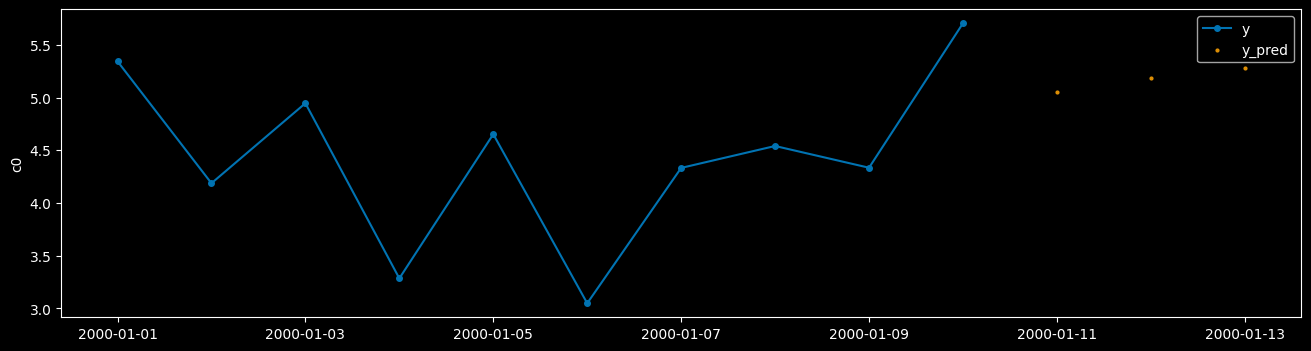

In [64]:
from sktime.utils.plotting import plot_series

plot_series(
    y_test.loc[("h0_99")],
    y_pred.loc[("h0_99")],
    labels=["y", "y_pred"],
)

### Global Forecast with exogeneous data

When we predict with exogeneous data, we need to pass both `X` and `y` to `predict`.

`X` must contain all historical values and the time points to be predicted while `y` should only contain the historical values but not the time points to be predicted.

In [65]:
from sktime.utils._testing.hierarchical import _make_hierarchical
from sklearn.model_selection import train_test_split

data = _make_hierarchical(
    hierarchy_levels=(100, 1), max_timepoints=10, min_timepoints=10, n_columns=2
)
data = data.droplevel(1)
x = data["c0"].to_frame()
y = data["c1"].to_frame()
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, train_size=0.9, shuffle=False
)
y_test = y_test.groupby(level=0).apply(
    lambda x: x.droplevel(0).iloc[:-3]
)

`X_train` and `y_train` have the same time index from 2000-01-01 to 2000-01-10.

However `y_test` is shorter than `X_test`. 

`X_test` has the time index from 2000-01-01 to 2000-01-10 but `y_test` only has the time index from 2000-01-01 to 2000-01-07. 

This is because we don't know the values from 2000-01-08 to 2000-01-10 of `y_test` which are going to be forecasted.

In [66]:
y_test

c1
h0    time                
h0_90 2000-01-01  2.651002
      2000-01-02  3.844442
      2000-01-03  3.762375
      2000-01-04  4.193379
      2000-01-05  4.017538
...                    ...
h0_99 2000-01-03  5.368671
      2000-01-04  6.380405
      2000-01-05  3.174925
      2000-01-06  3.798668
      2000-01-07  2.647241

[70 rows x 1 columns]

`y_test` is shorter than `X_test` as `y_test` only contains the historical values not the time points to be predicted.

Let's initialize a global forecaster which can handle exogeneous data.

In [67]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingTFT

In [68]:
model = PytorchForecastingTFT(
    trainer_params={
        "max_epochs": 5,  # for quick test
        "limit_train_batches": 10,  # for quick test
    },
    dataset_params={
        "max_encoder_length": 3,
    },
)

In [69]:
model.fit(y=y_train, X=X_train, fh=fh)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 32    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResid

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


PytorchForecastingTFT(dataset_params={'max_encoder_length': 3},
                      trainer_params={'limit_train_batches': 10,
                                      'max_epochs': 5})

Now we can predict on `y_test` with `X_test`.

In [70]:
y_pred = model.predict(fh=fh, X=X_test, y=y_test)
y_pred

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c1
h0    time                
h0_90 2000-01-08  4.362712
      2000-01-09  3.989582
      2000-01-10  4.582594
h0_91 2000-01-08  4.210225
      2000-01-09  4.588601
      2000-01-10  4.620286
h0_92 2000-01-08  4.383879
      2000-01-09  4.285245
      2000-01-10  4.648265
h0_93 2000-01-08  4.338478
      2000-01-09  3.951702
      2000-01-10  4.400213
h0_94 2000-01-08  4.240538
      2000-01-09  4.610684
      2000-01-10  3.930774
h0_95 2000-01-08  4.445383
      2000-01-09  4.213614
      2000-01-10  4.249535
h0_96 2000-01-08  4.417764
      2000-01-09  4.239827
      2000-01-10  4.052407
h0_97 2000-01-08  4.421465
      2000-01-09  4.506605
      2000-01-10  4.647429
h0_98 2000-01-08  4.281066
      2000-01-09  4.615709
      2000-01-10  4.622498
h0_99 2000-01-08  4.421319
      2000-01-09  4.345923
      2000-01-10  4.336202

We can plot one series to see the result. As we are using random data and only train the model for a few epochs, we can not expect too much.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='c1'>)

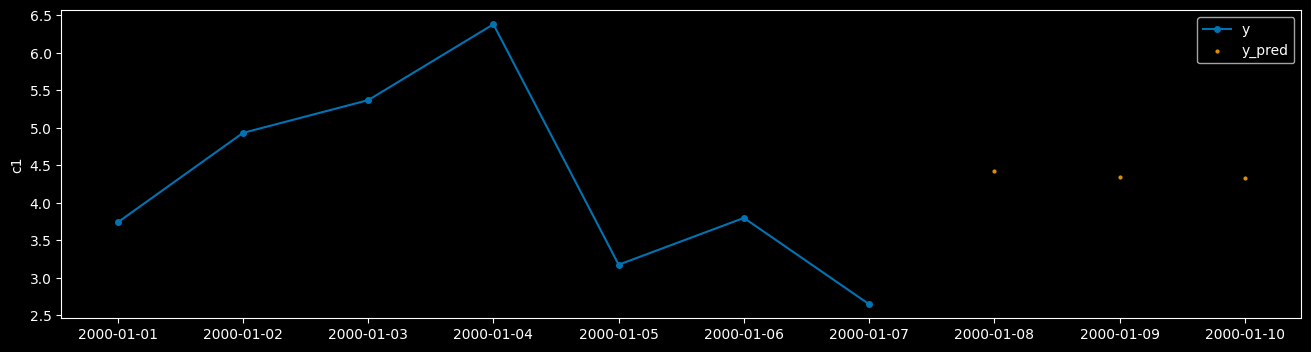

In [71]:
plot_series(
    y_test.loc[("h0_99")],
    y_pred.loc[("h0_99")],
    labels=["y", "y_pred"],
)